# Analysis of EEG data

EEG data collected during a go/no-go task. The participants were instructed to do a button press, when getting a certain auditory cue ("go" signal). During some of these trials, the partcipant would get a different auditory cue ("no-go" signal), and would then have to inhibit their response.

Data from two participants was collected. This notebook contains both preprocessing and analysis of the data.

## Overview
- Load modules and data
- Preprocessing
    - Filtering
    - Remove bad channels
    - Artefact removal (ICA)
    - Epoching
    - Evoked (i.e. averaging)
    - Preprocessing for participant 2
- Analysis

## Load modules and data

In [2]:
%matplotlib inline

In [3]:
import mne
import os

from trigger_function import convert_triggers

In [33]:
filepath_p1 = os.path.join("..", "data", "p1-raw.fif")
filepath_p2 = os.path.join("..", "data", "p2-raw.fif")

raw1 = mne.io.read_raw_fif(filepath_p1)
raw2 = mne.io.read_raw_fif(filepath_p2)

raw1.load_data()
raw2.load_data()

Opening raw data file ..\data\p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Opening raw data file ..\data\p2-raw.fif...
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...
Reading 0 ... 989399  =      0.000 ...   989.399 secs...


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

## Preprocessing

Firstly, all of the preproccessing will be done with data collected from participant one (raw1). Secondly, all of the steps are repeated for the data collected from participant two (raw2). The first part will be throughly commented, whereas the second part will only include the code.

### Filtering
- Lowpass: 40Hz
- Highpass: 0.1Hz

We first apply the highpass filter and then the lowpass filter.

In [5]:
filtered = raw1.copy().filter(l_freq=None, h_freq=40)
filtered = filtered.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [6]:
filtered.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Visual inspection
- Identify bad channels


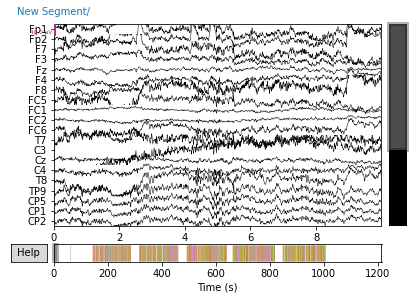

In [7]:
filtered.plot(); # plot signal from the different channels, to identify bad channels

In [8]:
# remove bad channel: C3
filtered.info['bads'] = ['C3']
filtered.info

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Artefact removal
- Independent Component Analysis (ICA)

Number of components for the ICA is chosen so that 95% if the variance is explain. The components are plotted so that we can inspect which components to exclude.

In [9]:
# set up and fit the ICA
# n_components until 95% of variance is explained
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 20.5s.


<ICA | raw data decomposition, fit (fastica): 1214580 samples, 11 components, channels used: "eeg">

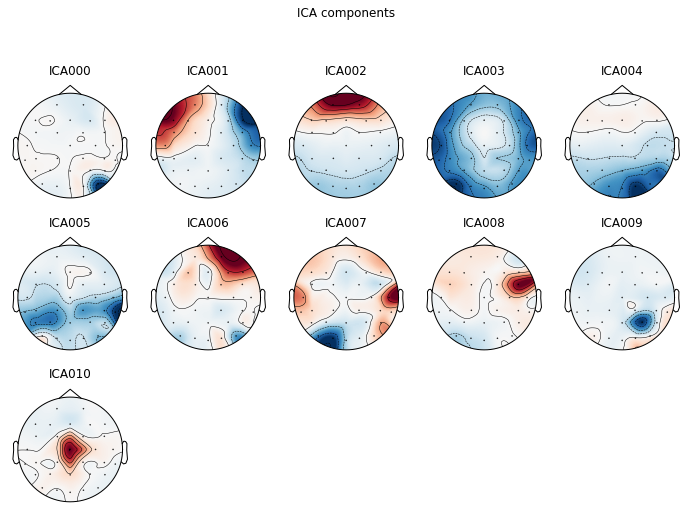

In [10]:
ica.plot_components();

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


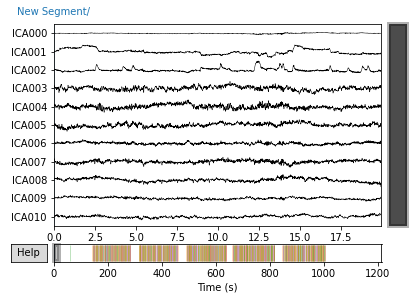

In [11]:
ica.plot_sources(filtered);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


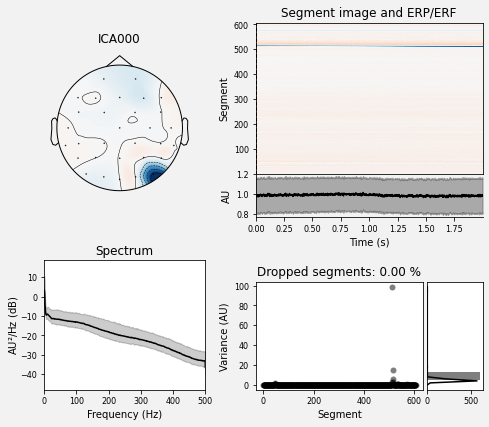

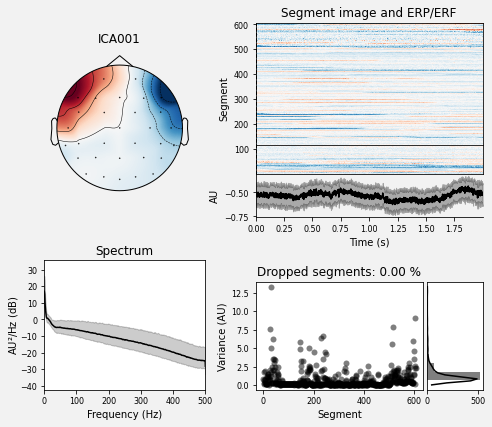

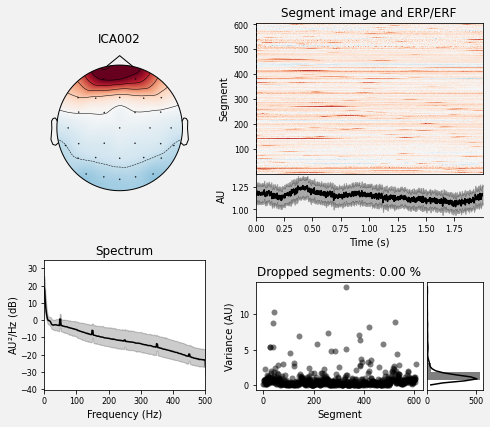

In [12]:
# Further inspection of components 0, 1, and 2
ica.exclude = [0, 1, 2] 
ica.plot_properties(raw1, picks=ica.exclude);

# 0: an artefact (muscle tension), 1: saccade, 2: eyeblink 

In [13]:
# apply ICA
orig_filtered = filtered.copy() # saving a copy of the original data
filtered.load_data()
ica.apply(filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

### Epoching
- tmin: 0.5, tmax: 1.55
- trigger value: check whether it is a succesful or failed response
- Reject all all epoch with signal over 150 µV
- Baseline: (None, 0)

In [14]:
events, _ = mne.events_from_annotations(filtered)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [15]:
# convert triggers according to button-press or no button-press
events, event_id = convert_triggers(events, return_event_ids=True)

C:\Users\Sara\AppData\Local\Temp/ipykernel_22216/2066702829.py:2: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events,
C:\Users\Sara\AppData\Local\Temp/ipykernel_22216/2066702829.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events,


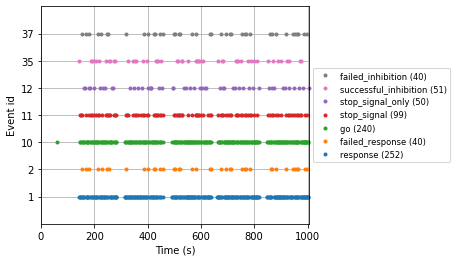

In [16]:
# visualize different events
mne.viz.plot_events(events,
                    sfreq=filtered.info['sfreq'], 
                    first_samp=filtered.first_samp, 
                    event_id=event_id);

# approx. same number of successful and failed inhibition, distributed equally across time

In [17]:
reject = dict(eeg=150e-6) # reject all epoch with signal over 150 µV
tmin, tmax = -0.5, 1.5

epochs = mne.Epochs(filtered, events, event_id, tmin, tmax,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
772 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 772 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['P4']
7 bad epochs dropped


In [18]:
epochs.info

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

In [19]:
epochs

Number of events,765
Events,failed_inhibition: 40failed_response: 40go: 238response: 250stop_signal: 98stop_signal_only: 49successful_inhibition: 50
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


### Evoked
- define conditions we care about: succesful and failed inhibition
- equalize event counts
- average

In [20]:
conds_we_care_about = ['successful_inhibition', 'failed_inhibition']

In [21]:
epochs.equalize_event_counts(conds_we_care_about)
suc_epochs = epochs['successful_inhibition']
fail_epochs = epochs['failed_inhibition']

Dropped 10 epochs: 55, 117, 129, 135, 174, 180, 184, 389, 395, 400


In [22]:
suc_epochs

Number of events,40
Events,successful_inhibition: 40
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


In [23]:
fail_epochs

Number of events,40
Events,failed_inhibition: 40
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


Visualizing the epochs from different channels (here we only show from Fp1)

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


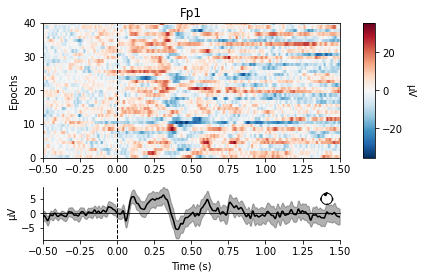

[<Figure size 432x288 with 4 Axes>]

In [24]:
suc_epochs.plot_image(picks=['Fp1'])

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


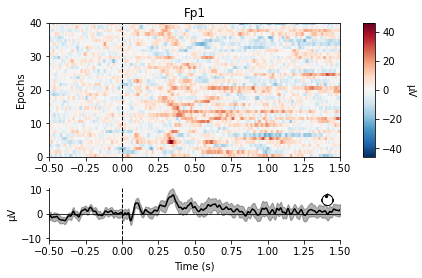

[<Figure size 432x288 with 4 Axes>]

In [25]:
fail_epochs.plot_image(picks=['Fp1'])

Calculate evoked signals. We also visualize the signals from the different channels together with the global field potential (gfp). Finally we compare the two evoked signals.

In [26]:
suc_evoked = suc_epochs.average()
fail_evoked = fail_epochs.average()

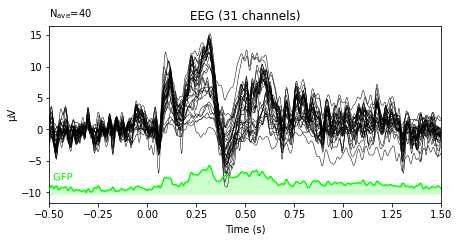

In [27]:
suc_evoked.plot(gfp=True);

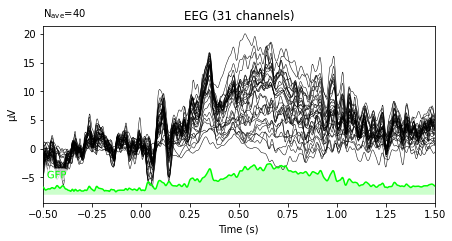

In [28]:
fail_evoked.plot(gfp=True);

No projector specified for this dataset. Please consider the method self.add_proj.


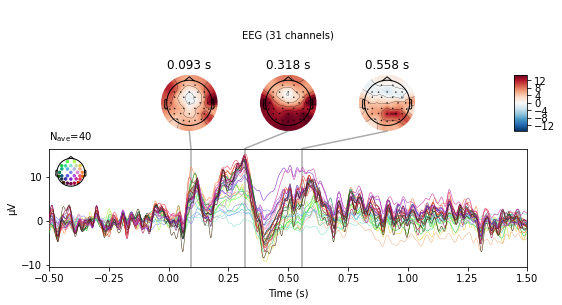

In [29]:
suc_evoked.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


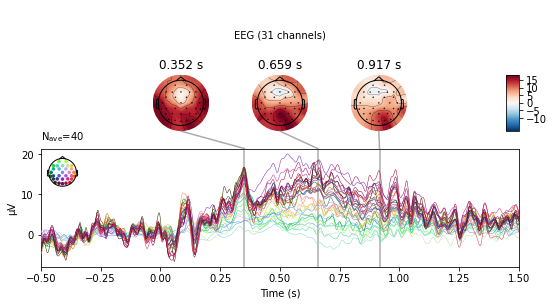

In [30]:
fail_evoked.plot_joint();

combining channels using "gfp"
combining channels using "gfp"


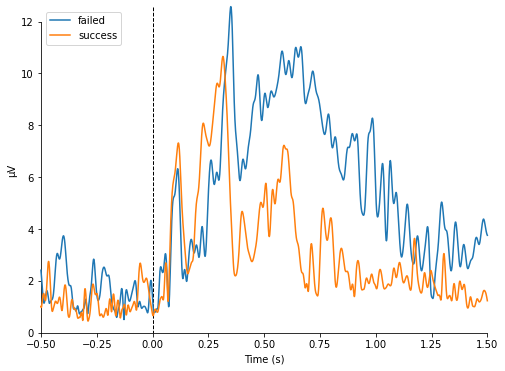

[<Figure size 576x432 with 1 Axes>]

In [31]:
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked, success=suc_evoked))

### Preprocessing for participant 2

#### Filtering

In [34]:
filtered2 = raw2.copy().filter(l_freq=None, h_freq=40)
filtered2 = filtered2.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



#### Visual inspection

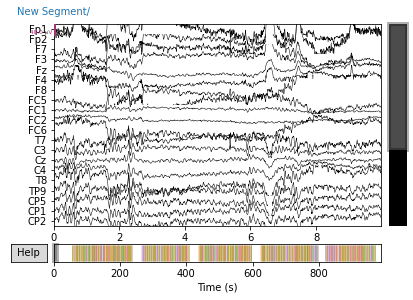

In [40]:
filtered2.plot(); # no bad channels

#### Artefact removal 

In [38]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(filtered2)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 10 components
Fitting ICA took 17.8s.


<ICA | raw data decomposition, fit (fastica): 989400 samples, 10 components, channels used: "eeg">

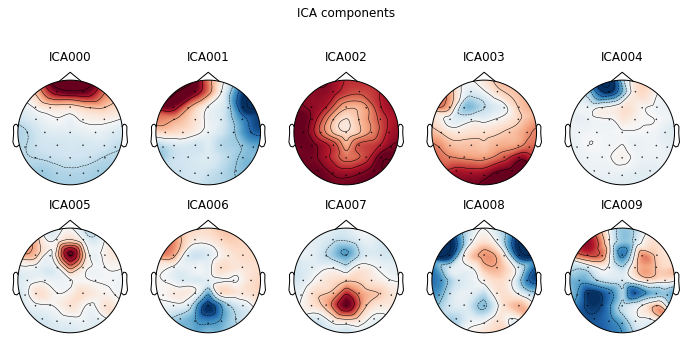

In [41]:
ica.plot_components();

Creating RawArray with float64 data, n_channels=10, n_times=989400
    Range : 0 ... 989399 =      0.000 ...   989.399 secs
Ready.


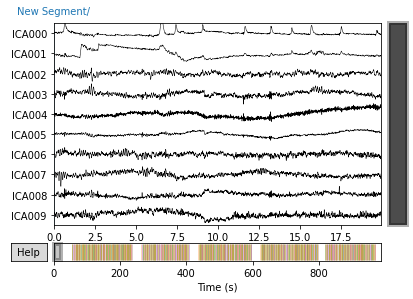

In [42]:
ica.plot_sources(filtered2);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
494 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


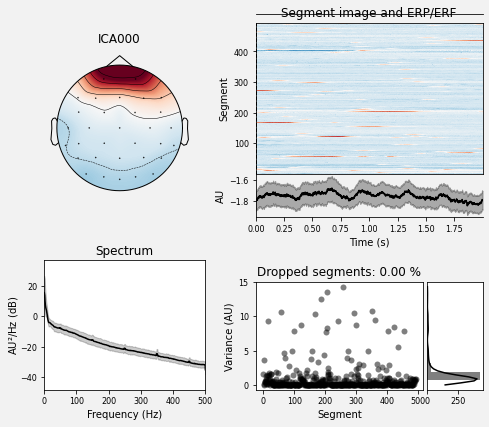

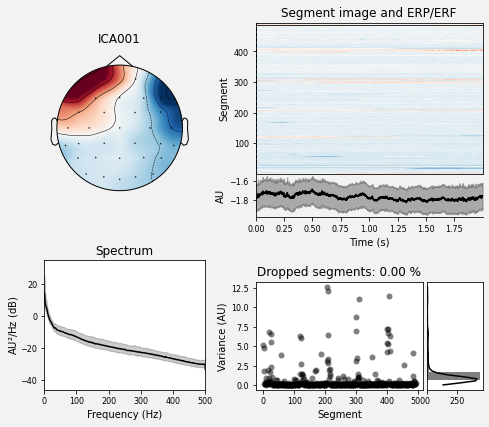

In [44]:
# Further inspection of components 0, and 1
ica.exclude = [0, 1] 
ica.plot_properties(raw2, picks=ica.exclude);

# 0: Eye blink, 1: saccade

In [45]:
# apply ICA
orig_filtered = filtered2.copy() # saving a copy of the original data
filtered2.load_data()
ica.apply(filtered2)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


<Raw | p2-raw.fif, 32 x 989400 (989.4 s), ~241.6 MB, data loaded>

#### Epoching

In [51]:
events2, _ = mne.events_from_annotations(filtered2)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [52]:
events2, event_id = convert_triggers(events2, return_event_ids=True)

C:\Users\Sara\AppData\Local\Temp/ipykernel_22216/3295647710.py:2: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events2,
C:\Users\Sara\AppData\Local\Temp/ipykernel_22216/3295647710.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events2,


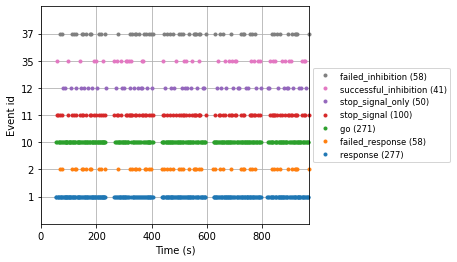

In [53]:
# visualize different events
mne.viz.plot_events(events2,
                    sfreq=filtered2.info['sfreq'], 
                    first_samp=filtered2.first_samp, 
                    event_id=event_id);

# approx. same number of successful and failed inhibition, distributed equally across time

In [54]:
reject = dict(eeg=150e-6) # reject all epoch with signal over 150 µV
tmin, tmax = -0.5, 1.5

epochs2 = mne.Epochs(filtered2, events2, event_id, tmin, tmax,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
855 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 855 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['TP9', 'TP10', 'P7', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO10']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['PO9', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rejecting  epoch based on EEG : ['Oz', 'O2', 'PO10']
    Rej

In [55]:
epochs2

Number of events,830
Events,failed_inhibition: 54failed_response: 55go: 267response: 273stop_signal: 95stop_signal_only: 46successful_inhibition: 40
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


#### Evoked

In [56]:
conds_we_care_about = ['successful_inhibition', 'failed_inhibition']

In [57]:
epochs2.equalize_event_counts(conds_we_care_about)
suc_epochs2 = epochs2['successful_inhibition']
fail_epochs2 = epochs2['failed_inhibition']

Dropped 14 epochs: 20, 65, 72, 100, 112, 317, 350, 359, 373, 402, 431, 454, 461, 478


In [59]:
suc_evoked2 = suc_epochs2.average()
fail_evoked2 = fail_epochs2.average()

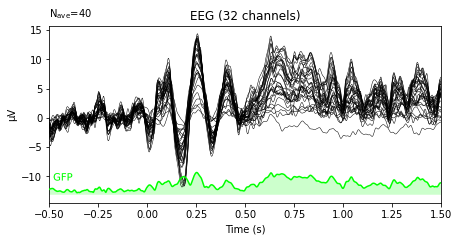

In [60]:
suc_evoked2.plot(gfp=True);

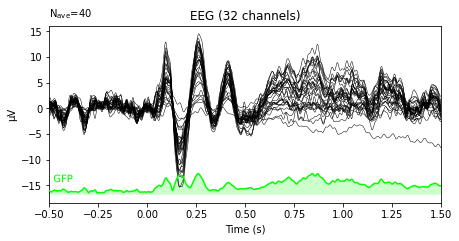

In [61]:
fail_evoked2.plot(gfp=True);

No projector specified for this dataset. Please consider the method self.add_proj.


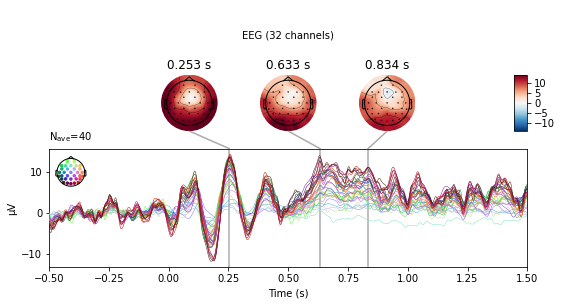

In [62]:
suc_evoked2.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


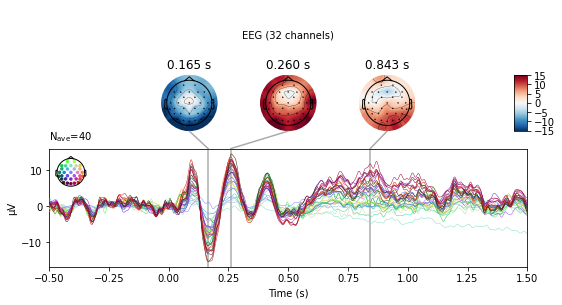

In [63]:
fail_evoked2.plot_joint();

combining channels using "gfp"
combining channels using "gfp"


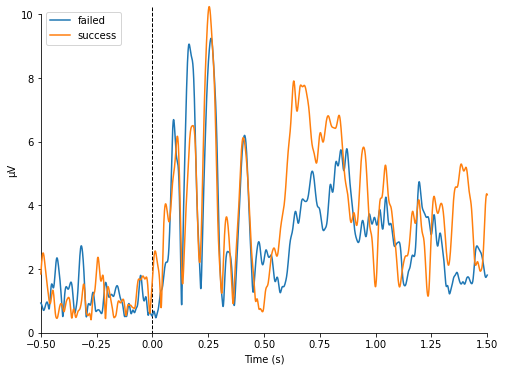

[<Figure size 576x432 with 1 Axes>]

In [64]:
mne.viz.plot_compare_evokeds(evokeds=dict(failed=fail_evoked2, success=suc_evoked2))